1. Importing Necessary Libraries

In [1]:
!pip install seaborn
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Car Price Prediction using XGBoost
This notebook trains a machine learning model to predict car prices using historical data.


In [2]:
import os

In [3]:
print(os.listdir())

['requirements.txt', 'LinearRegression.pkl', 'used_car_dataset.csv', 'README.md', 'static', 'app.py', 'templates', 'Car Dekho.ipynb', 'Procfile', 'venv', 'Clean Data.csv']


Loading the Publically avialable DataSet from kaggle(Car Dekho Dataset)

In [4]:
df=pd.read_csv("used_car_dataset.csv")

In [5]:
df.head()

,car_name,car_price_in_rupees,kms_driven,fuel_type,city,year_of_manufacture
0,Hyundai Grand i10 Magna 1.2 Kappa VTVT [2017-2...,₹ 4.45 Lakh,"22,402 km",Petrol,Mumbai,2016
1,Maruti Suzuki Alto 800 Lxi,₹ 2.93 Lakh,"10,344 km",Petrol,Kolkata,2019
2,Tata Safari XZ Plus New,₹ 22.49 Lakh,"12,999 km",Diesel,Bangalore,2021
3,Maruti Suzuki Ciaz ZXI+,₹ 6.95 Lakh,"45,000 km",Petrol,Thane,2016
4,Jeep Compass Sport Plus 1.4 Petrol [2019-2020],₹ 12 Lakh,"11,193 km",Petrol,Kolkata,2019


Removing all null valued rows

In [6]:
print(df.isnull().sum())

car_name               0
car_price_in_rupees    0
kms_driven             0
fuel_type              0
city                   0
year_of_manufacture    0
dtype: int64


In [7]:
print(df.info)

<bound method DataFrame.info of                                                car_name car_price_in_rupees  \
0     Hyundai Grand i10 Magna 1.2 Kappa VTVT [2017-2...         ₹ 4.45 Lakh   
1                            Maruti Suzuki Alto 800 Lxi         ₹ 2.93 Lakh   
2                               Tata Safari XZ Plus New        ₹ 22.49 Lakh   
3                               Maruti Suzuki Ciaz ZXI+         ₹ 6.95 Lakh   
4        Jeep Compass Sport Plus 1.4 Petrol [2019-2020]           ₹ 12 Lakh   
...                                                 ...                 ...   
2100                         Ford Figo Titanium1.5 TDCi          ₹ 3.6 Lakh   
2101                    MINI Cooper Countryman Cooper D           ₹ 22 Lakh   
2102                          Hyundai Verna 1.6 VTVT SX         ₹ 8.38 Lakh   
2103                         Maruti Suzuki Ciaz VXi+ AT         ₹ 6.75 Lakh   
2104                          Hyundai Verna 1.6 VTVT SX         ₹ 8.76 Lakh   

     kms_driven fue

In [8]:
print(df.columns)
df.rename(columns={'year_of_manufacture': 'Year'}, inplace=True) 
print(df.columns)

Index(['car_name', 'car_price_in_rupees', 'kms_driven', 'fuel_type', 'city',
       'year_of_manufacture'],
      dtype='object')
Index(['car_name', 'car_price_in_rupees', 'kms_driven', 'fuel_type', 'city',
       'Year'],
      dtype='object')


Calculating car age as it is pretty necessary feature

In [9]:
# Convert Year to Car Age
df['Car_Age'] = 2024 - df['Year']

# Drop the original Year column
df.drop(['Year'], axis=1, inplace=True)

print(df[['Car_Age']].head())  # Check the new feature


   Car_Age
0        8
1        5
2        3
3        8
4        5


In [10]:
df.drop(columns=['city'],axis=1, inplace=True)
#droping city as it does not hold much importance in predicting car price


In [11]:
#dropping duplicate values of car name
df = df.drop_duplicates()
df['car_name']=df['car_name'].str.split(' ').str.slice(0,3).str.join(' ')

In [12]:
df.head()

,car_name,car_price_in_rupees,kms_driven,fuel_type,Car_Age
0,Hyundai Grand i10,₹ 4.45 Lakh,"22,402 km",Petrol,8
1,Maruti Suzuki Alto,₹ 2.93 Lakh,"10,344 km",Petrol,5
2,Tata Safari XZ,₹ 22.49 Lakh,"12,999 km",Diesel,3
3,Maruti Suzuki Ciaz,₹ 6.95 Lakh,"45,000 km",Petrol,8
4,Jeep Compass Sport,₹ 12 Lakh,"11,193 km",Petrol,5


In [13]:
!pip install scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip



Coverting price and kms travelled in float value

In [14]:
def convert_price(price):
    price = str(price)  # Ensure everything is a string
    price = price.replace('₹', '').replace(',', '').strip()  # Remove ₹ and commas
    
    if 'Lakh' in price:
        return float(price.replace('Lakh', '').strip()) * 1_00_000  # Convert Lakh to number
    elif 'Crore' in price:
        return float(price.replace('Crore', '').strip()) * 1_00_00_000  # Convert Crore to number
    else:
        try:
            return float(price)  # Convert to float if it's already a number
        except ValueError:
            return None 

In [15]:
df['kms_driven'] = df['kms_driven'].astype(str)

# Remove commas and ' km' from the values
df['kms_driven'] = df['kms_driven'].str.replace(',', '').str.replace(' km', '', regex=True)

# Convert to numeric (float)
df['kms_driven'] = pd.to_numeric(df['kms_driven'], errors='coerce')

# Check for NaN values
print(df['kms_driven'].isnull().sum())

# Drop rows with missing values (if necessary)
df.dropna(subset=['kms_driven'], inplace=True)

print(df[['kms_driven']].head())

0
   kms_driven
0       22402
1       10344
2       12999
3       45000
4       11193


In [16]:
df['car_price_in_rupees'] = df['car_price_in_rupees'].apply(convert_price)

# Check for NaN values
print(df['car_price_in_rupees'].isnull().sum())

# Drop rows with missing values (if needed)
df.dropna(subset=['car_price_in_rupees'], inplace=True)

print(df[['car_price_in_rupees']].head()) 

0
   car_price_in_rupees
0             445000.0
1             293000.0
2            2249000.0
3             695000.0
4            1200000.0


In [17]:
df.head()

,car_name,car_price_in_rupees,kms_driven,fuel_type,Car_Age
0,Hyundai Grand i10,445000.0,22402,Petrol,8
1,Maruti Suzuki Alto,293000.0,10344,Petrol,5
2,Tata Safari XZ,2249000.0,12999,Diesel,3
3,Maruti Suzuki Ciaz,695000.0,45000,Petrol,8
4,Jeep Compass Sport,1200000.0,11193,Petrol,5


In [18]:
df['brand'] = df['car_name'].apply(lambda x: x.split()[0])  
df.head()
new_column_order = ['car_name', 'brand', 'Car_Age', 'car_price_in_rupees', 'kms_driven', 'fuel_type']

# Reorder DataFrame columns
df = df[new_column_order]

# Display the first few rows to confirm the change
df.head()

,car_name,brand,Car_Age,car_price_in_rupees,kms_driven,fuel_type
0,Hyundai Grand i10,Hyundai,8,445000.0,22402,Petrol
1,Maruti Suzuki Alto,Maruti,5,293000.0,10344,Petrol
2,Tata Safari XZ,Tata,3,2249000.0,12999,Diesel
3,Maruti Suzuki Ciaz,Maruti,8,695000.0,45000,Petrol
4,Jeep Compass Sport,Jeep,5,1200000.0,11193,Petrol


In [19]:
df.fuel_type.unique()

array(['Petrol', 'Diesel', 'Diesel + 1', 'Electric', 'CNG', 'Petrol + 1',
       'Hybrid', 'LPG'], dtype=object)

In [20]:
df.loc[df["fuel_type"] == "Diesel + 1", "fuel_type"] = "Diesel"
df.loc[df["fuel_type"] == "Petrol + 1", "fuel_type"] = "Petrol"

In [21]:
df.head()

,car_name,brand,Car_Age,car_price_in_rupees,kms_driven,fuel_type
0,Hyundai Grand i10,Hyundai,8,445000.0,22402,Petrol
1,Maruti Suzuki Alto,Maruti,5,293000.0,10344,Petrol
2,Tata Safari XZ,Tata,3,2249000.0,12999,Diesel
3,Maruti Suzuki Ciaz,Maruti,8,695000.0,45000,Petrol
4,Jeep Compass Sport,Jeep,5,1200000.0,11193,Petrol


<Axes: xlabel='fuel_type', ylabel='Count'>

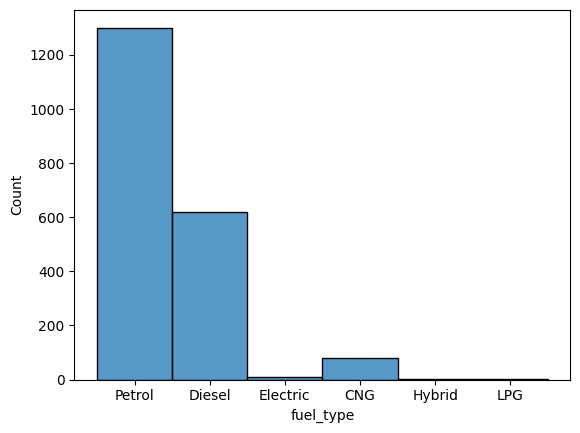

In [22]:
sns.histplot(df['fuel_type'])

Dropping CNG and Hybrid as they are very less in number creating nothing just outliers

In [23]:
df = df.drop(df[(df.fuel_type == "Hybrid")].index)
df = df.drop(df[(df.fuel_type == "LPG")].index)

<Axes: xlabel='fuel_type', ylabel='Count'>

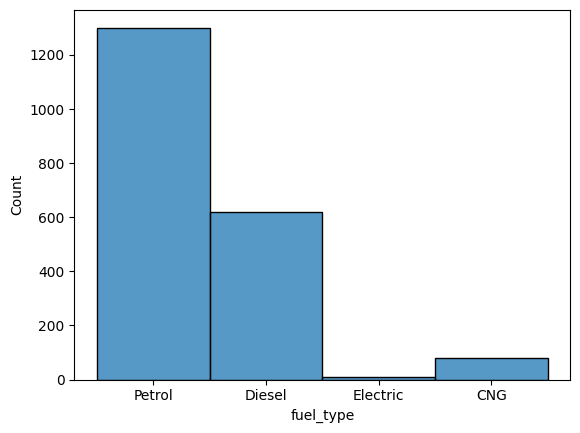

In [24]:
sns.histplot(df['fuel_type'])

In [25]:
df['fuel_type'].unique()


array(['Petrol', 'Diesel', 'Electric', 'CNG'], dtype=object)

In [26]:
df.describe()

,Car_Age,car_price_in_rupees,kms_driven
count,2009.000000,2.009000e+03,2.009000e+03
mean,6.977103,1.137953e+06,4.843985e+04
std,2.821459,1.354360e+06,8.550894e+04
min,2.000000,6.000000e+04,6.400000e+01
25%,5.000000,4.750000e+05,2.500000e+04
50%,7.000000,6.990000e+05,4.290600e+04
75%,9.000000,1.150000e+06,6.300000e+04
max,20.000000,1.950000e+07,3.600000e+06


In [27]:
df=df[df['car_price_in_rupees']<1e7].reset_index(drop=True)

In [28]:
df['fuel_type'].unique()
df['fuel_type'] = df['fuel_type'].replace(['Electric', 'CNG'], 'ecofriendly_fuel')


In [29]:
df['fuel_type'].unique()

array(['Petrol', 'Diesel', 'ecofriendly_fuel'], dtype=object)

MODEL

In [30]:
df.rename(columns={
    'car_name': 'name',
    'brand': 'company',
    'Car_Age': 'year',
    'car_price_in_rupees': 'price',
    'kms_driven': 'kms_driven',
    'fuel_type': 'fuel_type'  # Keeping this unchanged
}, inplace=True)

# Display the first few rows to confirm the changes
df.head()

,name,company,year,price,kms_driven,fuel_type
0,Hyundai Grand i10,Hyundai,8,445000.0,22402,Petrol
1,Maruti Suzuki Alto,Maruti,5,293000.0,10344,Petrol
2,Tata Safari XZ,Tata,3,2249000.0,12999,Diesel
3,Maruti Suzuki Ciaz,Maruti,8,695000.0,45000,Petrol
4,Jeep Compass Sport,Jeep,5,1200000.0,11193,Petrol


Removing outlier of CarAge

In [31]:
Q1 = df['year'].quantile(0.25)
Q3 = df['year'].quantile(0.75)
IQR = Q3 - Q1

# Using IQR to Filter Outliers
df_filtered = df[(df['year'] >= Q1 - 1.5 * IQR) & (df['year'] <= Q3 + 1.5 * IQR)]

df = df_filtered

In [32]:
df.head()

,name,company,year,price,kms_driven,fuel_type
0,Hyundai Grand i10,Hyundai,8,445000.0,22402,Petrol
1,Maruti Suzuki Alto,Maruti,5,293000.0,10344,Petrol
2,Tata Safari XZ,Tata,3,2249000.0,12999,Diesel
3,Maruti Suzuki Ciaz,Maruti,8,695000.0,45000,Petrol
4,Jeep Compass Sport,Jeep,5,1200000.0,11193,Petrol


In [33]:
X=df.drop(columns=['price'])
y=df['price']


In [34]:
df.to_csv('Clean Data.csv')

In [35]:
df.shape

(1989, 6)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
ohe=OneHotEncoder()
ohe.fit(X[['name','company','fuel_type']])
col_tr = ColumnTransformer([
    ("encoder", OneHotEncoder(handle_unknown='ignore'), ['name', 'fuel_type','company'])  # Correct structure
], remainder='passthrough')
lin_reg=LinearRegression()
pipe = make_pipeline(col_tr, lin_reg)

# Train the model
pipe.fit(X_train, y_train)


,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Use XGBRegressor
XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm widely used for regression and classification tasks. We used XGBoost Regressor in our Car Price Prediction Model for the following reasons:
1. Handles Complex Relationships Between Features
2. High Accuracy and Performance
3. Handles Missing and Categorical Data Efficiently
4. Regularization to Prevent Overfitting
5. Fast Training Speed & Parallel Processing

In [37]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
pipe = make_pipeline(col_tr, xgb_model)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("XGBoost R² Score:", r2)


XGBoost R² Score: 0.8675189812849297


R2 Score=0.86
accuracy=86%

In [38]:
import pickle

SAVED MY FILE

In [39]:
pickle.dump(pipe,open('LinearRegression.pkl','wb'))

Just testing via custom input

In [40]:
import pandas as pd

# Define input data (excluding price since it's the target variable)
input_data = pd.DataFrame([['Hyundai Grand i10', 'Hyundai', 5, 356789, 'Petrol']], 
                          columns=['name', 'company', 'year', 'kms_driven', 'fuel_type'])

# Make prediction
predicted_price = pipe.predict(input_data)

print("Predicted Price:", predicted_price[0])


Predicted Price: 652455.8
